In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.linalg
from math import sqrt

from problem import ElecVehCharg
from algorithms import UDC
import networkx as nx
import matplotlib.pyplot as plt
from plot_utils import MyFigure, MyFigureThree

# Set up the logger to print info messages for understandability.
import logging
import sys
import os
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

import json

Text(0.5, 1.0, '2 cliques')

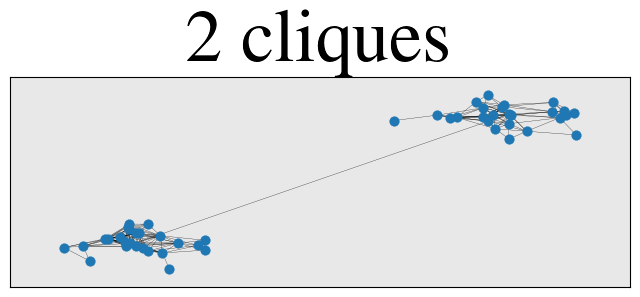

In [288]:
# read network graphs

N = 50  # num of nodes

graph_dir = 'graphs'
graph_names = [
    'complete_graph',
    'erdos_renyi_graph',
    'geometric_random_graph',
    '2_cliques',
    'ring_graph',
    'spanning_tree'
]
graphs = {}

for name in graph_names:
    with open(f'{graph_dir}/{name}.json') as f:
        data = json.load(f)
        graphs[name] = nx.node_link_graph(data, edges="links")

# test data
name = '2_cliques'
G = graphs[name]
nodes_data = G.nodes.data()
pos = {i: nodes_data[i]['pos'] for i in range(N)}

options = {
    # 'node_color': 'black',
    # 'arrowsize': 3,
    'node_size': 50,
    'width': 0.2,
    'linewidths': 0.2,
    'with_labels': False,
}

subax1 = plt.subplot(211)
nx.draw_networkx(G, pos=pos, **options)
subax1.set_title(name.replace('_', ' '))

In [13]:
# generate problem data
# N = 50
prob = ElecVehCharg(N)
# prob = Synthetic(parameters, debug=True)

prob.gen()
prob.load()
# print(f'x* {prob.x_star}')
print(f'||x*|| {np.linalg.norm(prob.x_star)}')

# g = prob.opt_cons_vio
# Mg = np.identity(num_node) - network
# g_in_Null_H = sqrt(g.T @ Mg @ g)
# g_norm = np.linalg.norm(g)
# print(f'||tilg(x*)|| {g_norm}')
# print(f'1 - ||tilg(x*)||_H / ||tilg(x*)|| {1-g_in_Null_H/g_norm}\n')

generating a ElecVehCharg problem, N=50
x* [ 1.05e-11 -2.81e-13  1.57e-10  1.34e-01  1.00e+00  1.00e+00  4.11e-11
  1.00e+00  1.44e-11  2.08e-11  1.82e-11 -2.95e-12  7.93e-11  2.41e-01
  6.02e-01  1.00e+00  7.16e-13  7.53e-11  2.46e-11 -1.57e-12  2.21e-01
 -4.09e-12  3.07e-02  8.66e-01  1.83e-02  1.91e-01  1.00e+00  1.00e+00
  3.73e-12 -5.50e-13  3.41e-11  8.72e-12  4.35e-12  9.60e-02  2.00e-02
  1.00e+00  6.80e-11  1.68e-11  8.81e-11  5.56e-11  7.58e-12  2.72e-11
  1.09e-10  2.23e-11  1.00e+00  1.00e-11  5.17e-11  7.23e-02  4.08e-12
  1.17e-01], f* 2.1073939612320154
generated problem saved in problem_data/N50
loading a ElecVehCharg problem, N=50
problem loaded:
c (50,)
d (50,)
b (1,)
x_star (50,)
opt_val 2.1073939612320154
||x*|| 3.050188293502867


In [3]:
# # load instance 1
N = 50
instance_name = 'instance1_N50'
instance_dir = 'problem_data/' + instance_name

# problem data
prob = ElecVehCharg(N)
prob.save_dir = instance_dir
prob.load()

print(f'x* {prob.x_star}')
print(f'||x*|| {np.linalg.norm(prob.x_star)}\n')

# network adjacency matrices
networks = {}
for name, G in graphs.items():
    networks[name] = nx.to_numpy_array(G)
    
print(networks['2_cliques'].shape)


loading a ElecVehCharg problem, N=50
problem loaded:
c (50,)
d (50,)
b (1,)
x_star (50,)
opt_val 1.209571107526383
x* [-2.11401576e-12  1.28881545e-11  1.38898171e-12  2.43160426e-11
  4.16490051e-11  7.55921004e-10  4.32310566e-12  7.07364358e-12
  5.82929481e-01  1.58987190e-11 -3.37208266e-12  1.00000000e+00
  5.25798562e-11  4.13658467e-11  3.53306348e-14 -4.03367475e-12
  6.13188115e-01  1.17113193e-12  5.55763272e-11  1.43528376e-11
  8.75441609e-12  3.23188039e-01  9.99999999e-01  2.61028772e-10
  1.63091895e-11  1.62559645e-10  1.00000000e+00  9.95318428e-05
  6.42030173e-11  1.00000000e+00  4.45583690e-11  1.13120622e-10
  2.89104645e-11  1.00000000e+00  1.00000000e+00  1.00000000e+00
  3.11873916e-11  5.40684449e-01  4.49118111e-01  2.94163642e-11
 -3.98174369e-13 -6.33292486e-12  4.14074177e-11  2.36615806e-11
  1.74125065e-10  2.02838437e-01  9.23193847e-11  4.74930097e-11
  3.03050204e-01  8.10488687e-13]
||x*|| 2.9064216087874417

(50, 50)


In [15]:
# prepare figures

figures = MyFigureThree()

log_dir = 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
np.set_printoptions(formatter={'float':lambda x: f' {x:.2e}' if x>0 else f'{x:.2e}'})

In [211]:
# UDC finetuning

# best rho (for Erdos Renyi graph, with avg oe+cv):
# PEXTRA:   0.5
# PGC:      0.1
# DPGA:     0.01
# D.A.:     0.5
# ALT:      1

# best rho (with last iter oe+cv):
#               comp    e_r     geo_r   2_c     ring    s_t
# PEXTRA:       1       1       2       2       2       2
# PGC:          0.2     0.2     0.2     0.2     1       1
# D.A.:         0.1     0.2     0.5     0.5     4       4
# ALT:          1


MAX_ITER = 500
# MAX_ITER = 2000
# MAX_ITER = 3000

# rho_choice = [0.1, 1, 10]
rho_choice = [
    # 0.0078125,
    # 0.015625,
    # 0.03125,
    # 0.0625,
    # 0.125, 
    # 0.25, 
    0.5, 
    1, 
    2, 
    4, 
    8, 
    # 16,
    # 32
]
# rho_choice = [0.1, 0.2, 0.5, 1, 2]
# rho_choice = [0.05, 0.1, 0.2, 0.5, 1, 2, 4, 10]
# rho_choice = [0.01, 0.02, 0.03]
# rho_choice = [1]

figures.clear()

graph_names = [
    'complete_graph',
    'erdos_renyi_graph',
    'geometric_random_graph',
    '2_cliques',
    # 'ring_graph',
    'spanning_tree'
]
param_settings = [
    # 'PEXTRA', 
    # 'PGC', 
    # # 'DPGA', 
    # 'DistADMM', 
    # 'ALT'
    'New1'
]

# param_settings = ['DistADMM', 'ALT']
# param_setting = param_settings[3]

for graph_name in graph_names:
    print(f'graph: {graph_name}')
    graph_adj = networks[graph_name]
    log_dir = f'log/{graph_name}'
    
    for param in param_settings:
        figures.clear()
        for rho in rho_choice:
            # rho = 1
            
            if True:
            # if rho != 1:
            # if rho == 32:
            # if rho == 0.2:
            # if rho != 0.1:
            # if rho == 0.005:
                alg = UDC(prob, log_dir, graph_adj, rho=rho, alpha=0,
                            param_setting=param, verbose=False)
                for i in range(MAX_ITER):
                    alg.step()

            # save convergence plot from files    
            log_prefix = f'{alg.name}_a{0}_r{rho}'
            figures.add_lines(graph_name, log_prefix)
            figures.paint(MAX_ITER=MAX_ITER)

graph: complete_graph
UDC setting: New1
d: (50,)
reset
UDC_New1 alpha 0 rho 0.5, iter 0, obj err: 1.21e+00, cons vio: 5.00e+00
time 0.02, saved

UDC_New1 alpha 0 rho 0.5, iter 100, obj err: 1.94e-06, cons vio: 3.47e-06
time 1.00, saved

UDC_New1 alpha 0 rho 0.5, iter 200, obj err: 8.75e-07, cons vio: 1.67e-06
time 1.98, saved

UDC_New1 alpha 0 rho 0.5, iter 300, obj err: 6.76e-07, cons vio: 0.00e+00
time 2.98, saved

UDC_New1 alpha 0 rho 0.5, iter 400, obj err: 1.50e-06, cons vio: 2.72e-06
time 4.03, saved

UDC_New1 alpha 0 rho 0.5, iter 500, obj err: 8.40e-07, cons vio: 1.61e-06
time 5.05, saved

UDC setting: New1
d: (50,)
reset
UDC_New1 alpha 0 rho 1, iter 0, obj err: 1.21e+00, cons vio: 5.00e+00
time 0.00, saved

UDC_New1 alpha 0 rho 1, iter 100, obj err: 7.21e-09, cons vio: 1.44e-07
time 1.05, saved

UDC_New1 alpha 0 rho 1, iter 200, obj err: 5.41e-07, cons vio: 1.04e-06
time 2.08, saved

UDC_New1 alpha 0 rho 1, iter 300, obj err: 3.92e-07, cons vio: 7.89e-07
time 3.11, saved

UDC_

In [252]:
# find the first "k" and "rho" that 
# "alg" achieve oe+cv < "eps" at "graph" 

epss = [1e-1 * prob.opt_val, 
        1e-2 * prob.opt_val, 
        1e-3 * prob.opt_val, 
        1e-4 * prob.opt_val]

alg_names = ['UDC_New1', 'UDC_PEXTRA', 'UDC_PGC', 'UDC_DistADMM', 'ALT']
graph_names = [
    'complete_graph',
    'erdos_renyi_graph',
    'geometric_random_graph',
    '2_cliques',
    'ring_graph',
    'spanning_tree'
]
rho_choice = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, \
    1, 2, 4, 8, 16, 32]

best_rhos = []
first_ks = []

# asign a list of k's for each alg, prepare for plotting 
first_ks_alg_lists = [] 

for i in range(4): # iterate through 4 eps
    best_rhos.append({})
    first_ks.append({})
    for alg in alg_names:
        best_rhos[i][alg] = {}
        first_ks[i][alg] = {}
        
        for graph in graph_names:
            # load all rho choices,     
            # find first k for eah file,
            # then compare these k  
            first_k = np.zeros(len(rho_choice), dtype=np.int64)
            
            for rho in rho_choice:
                k = 3001
                filename = f'log/{graph}/{alg}_a0_r{rho}_oe_cv.txt'
                if os.path.exists(filename):
                    log = np.loadtxt(filename)
                    indices = np.argwhere(log < epss[i])
                    if indices.shape[0] != 0: # if oe+cv is not always above eps
                        k = indices[0, 0]                
                first_k[rho_choice.index(rho)] = k
                
            best_rho = rho_choice[np.argmin(first_k)]
            best_rhos[i][alg][graph] = best_rho
            first_ks[i][alg][graph] = np.min(first_k)
    # print(np.min(first_k))
    # print(best_rhos)
    # print(first_ks)
        

    # asign a list of k's for each alg, prepare for plotting 
    first_ks_alg_lists.append({})
    for alg in alg_names:
        first_ks_alg_lists[i][alg] = []
        for graph in graph_names:
            first_ks_alg_lists[i][alg].append(first_ks[i][alg][graph])
            
            
print(first_ks_alg_lists)
print(best_rhos)

[{'UDC_New1': [9, 5, 7, 6, 8, 3], 'UDC_PEXTRA': [2, 2, 2, 2, 2, 2], 'UDC_PGC': [6, 11, 27, 21, 6, 6], 'UDC_DistADMM': [5, 4, 7, 14, 2, 2], 'ALT': [2, 2, 2, 2, 2, 2]}, {'UDC_New1': [10, 23, 14, 14, 17, 41], 'UDC_PEXTRA': [2, 35, 18, 20, 12, 28], 'UDC_PGC': [16, 13, 31, 25, 29, 13], 'UDC_DistADMM': [21, 51, 24, 43, 83, 16], 'ALT': [2, 17, 2, 17, 12, 52]}, {'UDC_New1': [23, 25, 109, 14, 78, 41], 'UDC_PEXTRA': [28, 45, 118, 60, 12, 73], 'UDC_PGC': [34, 40, 75, 105, 29, 41], 'UDC_DistADMM': [85, 74, 197, 86, 191, 16], 'ALT': [35, 238, 200, 101, 48, 405]}, {'UDC_New1': [46, 61, 153, 177, 182, 90], 'UDC_PEXTRA': [47, 89, 148, 176, 137, 153], 'UDC_PGC': [34, 53, 183, 174, 120, 41], 'UDC_DistADMM': [206, 187, 1008, 181, 668, 279], 'ALT': [67, 615, 451, 280, 418, 411]}]
[{'UDC_New1': {'complete_graph': 0.5, 'erdos_renyi_graph': 0.5, 'geometric_random_graph': 0.5, '2_cliques': 0.5, 'ring_graph': 1, 'spanning_tree': 0.5}, 'UDC_PEXTRA': {'complete_graph': 0.125, 'erdos_renyi_graph': 0.125, 'geometr

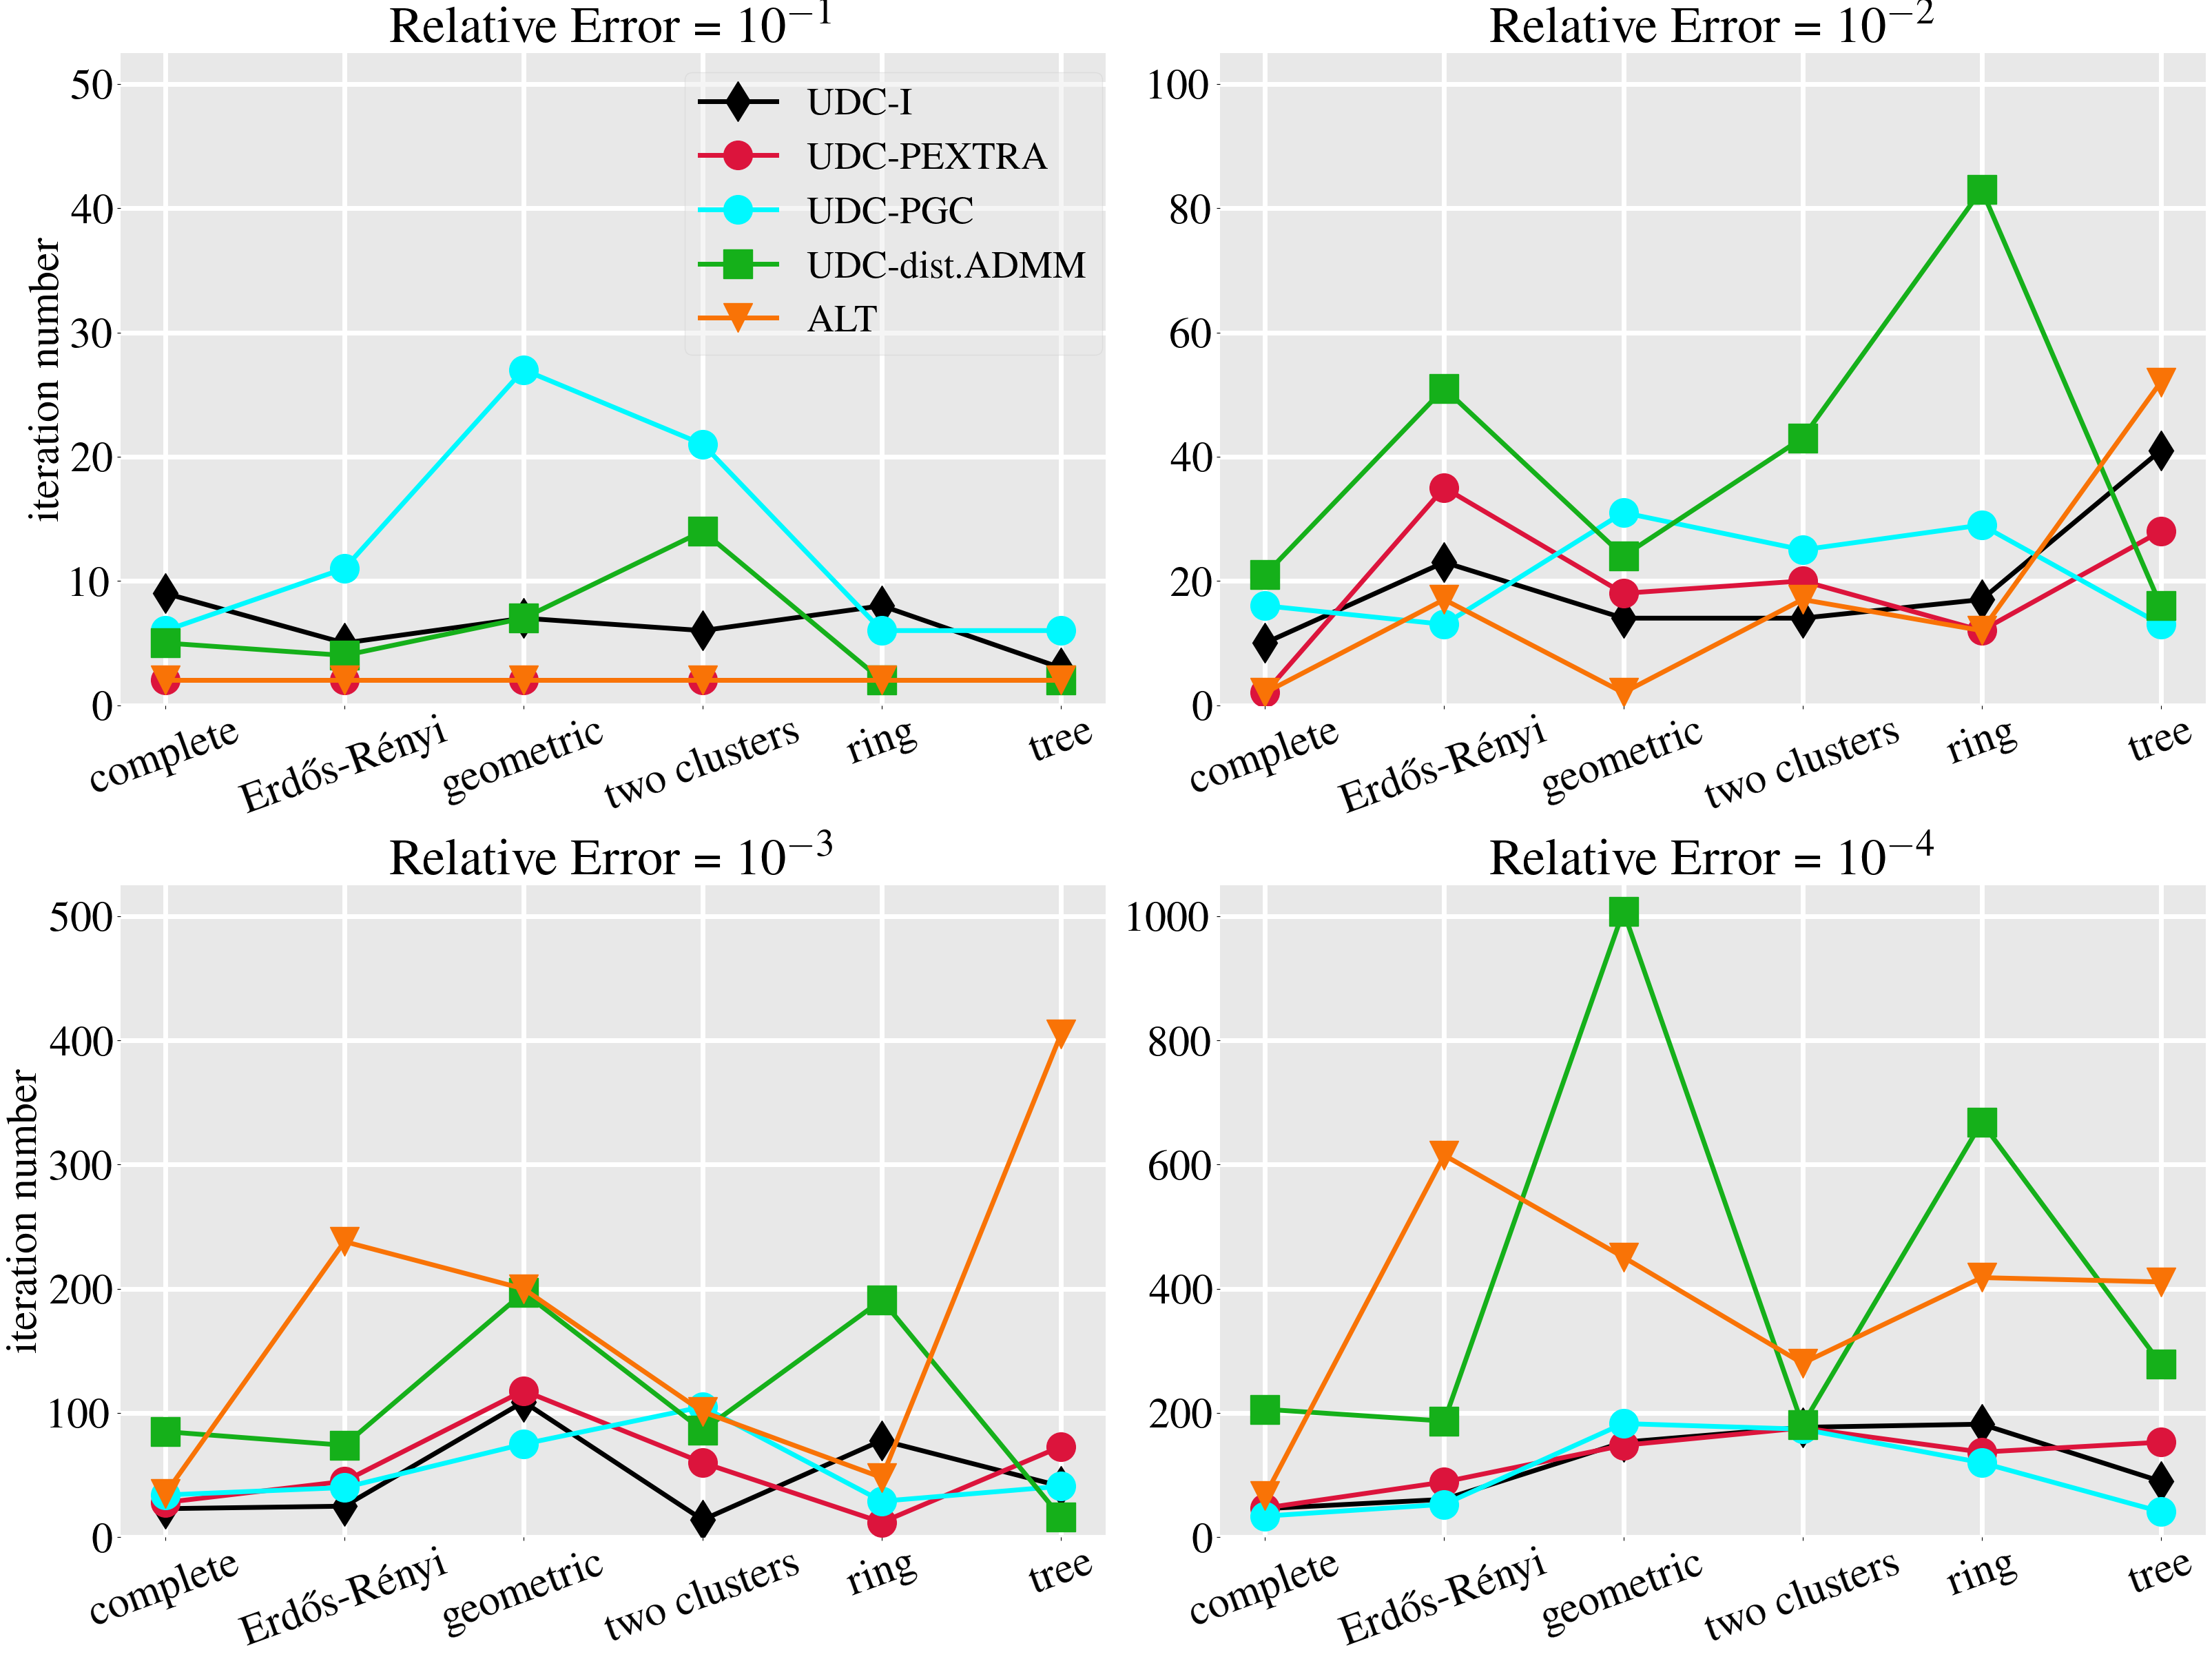

In [298]:
# plot four figures

from matplotlib import rc, font_manager
from matplotlib.ticker import FormatStrFormatter, LogFormatter
from matplotlib.legend_handler import HandlerTuple

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times",
    "font.sans-serif": "Helvetica",
    "font.size": 45,
    # 'text.latex.preamble': r'\usepackage{sfmath}' # sans-serif for math
    'text.latex.preamble': r'\usepackage{newtxtext} \usepackage{amssymb} \usepackage{amsmath}',
    'axes.facecolor': '#e8e8e8'
})

alg_names_plot = {
    'UDC_New1': 'UDC-I',
    'UDC_PEXTRA': 'UDC-PEXTRA',
    'UDC_PGC': 'UDC-PGC',
    'UDC_DistADMM': 'UDC-dist.ADMM',
    'ALT': 'ALT'
}

graph_names_plot = [
    'complete',
    'Erdős-Rényi',
    'geometric',
    'two clusters',
    'ring',
    'tree'
]
ls = {
    'UDC_New1':'d-', 
    'UDC_PEXTRA':'o-', 
    'UDC_PGC':'o-', 
    'UDC_DistADMM':'s-', 
    'ALT':'v-'
}

# set line colors
c = {
    'UDC_PEXTRA'        : 'crimson',
    'UDC_PGC'           : '#00f9ff',   # sky blue
    'UDC_DPGA'          : 'goldenrod',   # blue gray
    'UDC_DistADMM'      : 'xkcd:green',
    'ALT'               : 'xkcd:orange',
    'DPMM'              : 'lightseagreen',
    'IPLUX'             : 'xkcd:purple',
    'dual_subgradient'  : 'olive',
    'UDC_New1'          : 'black'
}

ylimits = [(0, 52.5), (0, 105), (0,525), (0,1050)]
titles = [r'Relative Error = $10^{-1}$', r'Relative Error = $10^{-2}$', r'Relative Error = $10^{-3}$', r'Relative Error = $10^{-4}$']
ylabels = [r'iteration number', '', r'iteration number', '']

fig, axs = plt.subplot_mosaic([[0, 1],[2, 3]], 
                              layout='constrained',
                              figsize=(32, 24))

for i in range(4):
    axs[i].set_title(titles[i])
    axs[i].set_ylim(ylimits[i])
    # axs[i].set_xlabel(r'''$\mathrm{(a)}$''', fontsize=45)
    axs[i].set_ylabel(ylabels[i], fontsize=45)
    axs[i].spines.bottom.set_linewidth(0)
    axs[i].spines.top.set_linewidth(0)
    axs[i].spines.left.set_linewidth(0)
    axs[i].spines.right.set_linewidth(0)
    axs[i].grid(True, lw=5, color='1')
    for label in axs[i].get_xticklabels(which='major'):
        label.set(rotation=20, horizontalalignment='center')

handles = []
handles = [i for i in range(len(alg_names))]
for i in range(4):
    for alg in alg_names:
        handles[alg_names.index(alg)], = \
            axs[i].plot(graph_names_plot, 
                        first_ks_alg_lists[i][alg],
                        ls[alg], 
                        markersize = 30,
                        linewidth = 5,
                        color = c[alg],
                        label=alg_names_plot[alg])
        
fig.legend(handles=handles, 
           fontsize=40,  
           bbox_to_anchor=(0.3, 0.97), # bbox (x, y, width, height)
           loc='upper left', 
           ncols=1, 
           framealpha=0.4)
fig.savefig(f'iter_to_rel_err.pdf', bbox_inches='tight', pad_inches=0.5, transparent=False)

{0: array([ 1.00e+00, -7.49e-09]), 1: array([ 9.92e-01,  1.25e-01]), 2: array([ 9.69e-01,  2.49e-01]), 3: array([ 9.30e-01,  3.68e-01]), 4: array([ 8.76e-01,  4.82e-01]), 5: array([ 8.09e-01,  5.88e-01]), 6: array([ 7.29e-01,  6.85e-01]), 7: array([ 6.37e-01,  7.71e-01]), 8: array([ 5.36e-01,  8.44e-01]), 9: array([ 4.26e-01,  9.05e-01]), 10: array([ 3.09e-01,  9.51e-01]), 11: array([ 1.87e-01,  9.82e-01]), 12: array([ 6.28e-02,  9.98e-01]), 13: array([-6.28e-02,  9.98e-01]), 14: array([-1.87e-01,  9.82e-01]), 15: array([-3.09e-01,  9.51e-01]), 16: array([-4.26e-01,  9.05e-01]), 17: array([-5.36e-01,  8.44e-01]), 18: array([-6.37e-01,  7.71e-01]), 19: array([-7.29e-01,  6.85e-01]), 20: array([-8.09e-01,  5.88e-01]), 21: array([-8.76e-01,  4.82e-01]), 22: array([-9.30e-01,  3.68e-01]), 23: array([-9.69e-01,  2.49e-01]), 24: array([-9.92e-01,  1.25e-01]), 25: array([-1.00e+00, -9.49e-08]), 26: array([-9.92e-01, -1.25e-01]), 27: array([-9.69e-01, -2.49e-01]), 28: array([-9.30e-01, -3.68e-

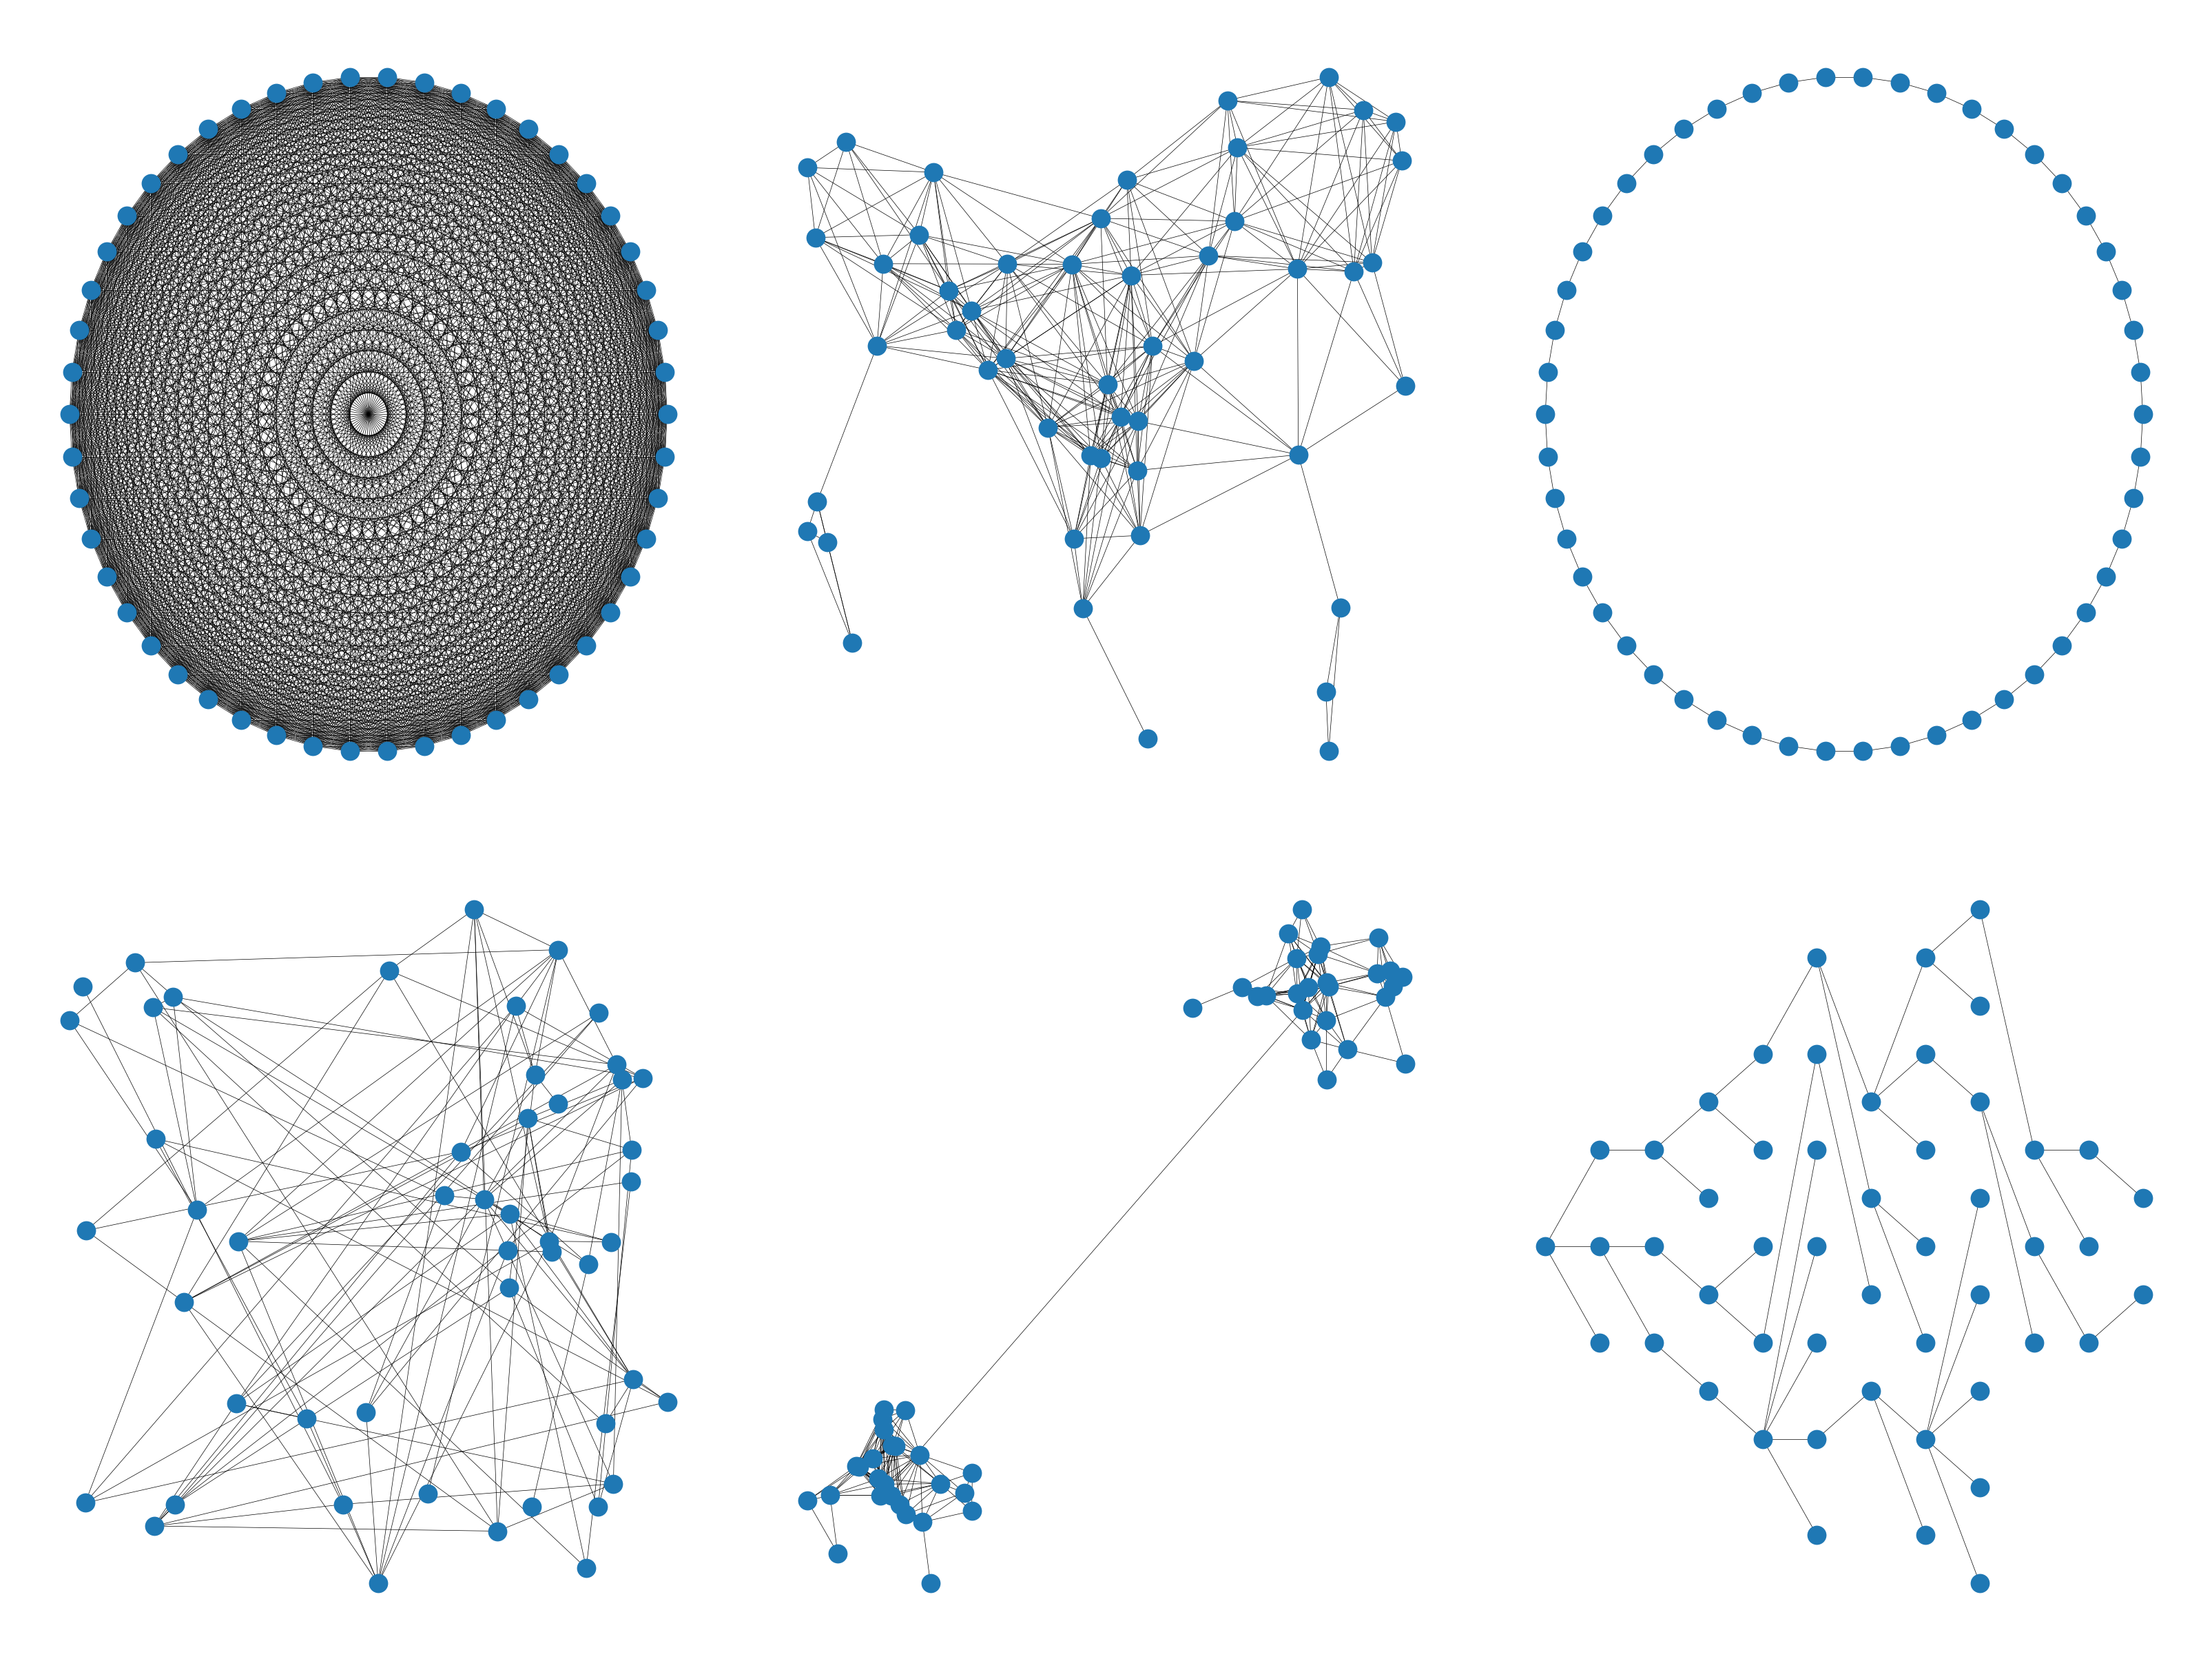

In [320]:
# plot graphs

plt.rcParams.update({
    'axes.facecolor': '#ffffff'
})

# load graphs
N = 50  # num of nodes
graph_dir = 'graphs'
graph_names = [
    'complete_graph',
    'erdos_renyi_graph',
    'geometric_random_graph',
    '2_cliques',
    'ring_graph',
    'spanning_tree'
]
graphs = {}
for name in graph_names:
    with open(f'{graph_dir}/{name}.json') as f:
        data = json.load(f)
        graphs[name] = nx.node_link_graph(data, edges="links")


# prepare positions for plotting
poss = {}
for name in graph_names:
    G = graphs[name]
    nodes_data = G.nodes.data()
    pos = {}
    
    if name == '2_cliques' or name == 'geometric_random_graph':
        pos = {i: nodes_data[i]['pos'] for i in range(N)}
    elif name == 'complete_graph' or name == 'ring_graph':
        pos = nx.circular_layout(G)
    elif name == 'erdos_renyi_graph':
        pos = nx.random_layout(G)
    elif name == 'spanning_tree':
        pos = nx.bfs_layout(G, start=0)
    poss[name] = pos
    print(pos)
    
    
fig, axs = plt.subplot_mosaic([[0, 2, 4],[1, 3, 5]], 
                              layout='constrained',
                              figsize=(32, 24))

for i in range(6):
    # axs[i].set_title(titles[i])
    # axs[i].set_ylim(ylimits[i])
    # # axs[i].set_xlabel(r'''$\mathrm{(a)}$''', fontsize=45)
    # axs[i].set_ylabel(ylabels[i], fontsize=45)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    
    
options = {
    # 'node_color': 'black',
    # 'arrowsize': 3,
    'node_size': 400,
    'width': 0.5,
    'linewidths': 0.01,
    'with_labels': False,
}
for name in graph_names:
    i = graph_names.index(name)
    G = graphs[name]
    nx.draw_networkx(G, pos=poss[name], ax=axs[i], **options)

fig.savefig(f'graphs.pdf', bbox_inches='tight', transparent=False)